## Predicting Bicycle Trip Duration Based on Weather Conditions, Route, and Season

### In the previous notebook, we formulated the hypothesis: The main factor influencing the duration of the trip is the distance traveled.
#### Now, we will attempt to build a model to predict the duration of the bike trip in order to confirm this hypothesis.

## Part II - Development of the Regression Model

### Importing libraries

In [1]:
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Importing data

In [2]:
trip_data = pd.read_csv('trip_data_cleaned.csv')
trip_data = trip_data.drop(columns=['Unnamed: 0'])

### Normalizing the Features

In [3]:
X = trip_data.drop(columns=['duration'])
y = trip_data['duration']

scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

### First, we will split our dataset into training and test sets with an 80/20 ratio.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y,
    test_size=0.2,
    random_state=0
)

### We will build a simple linear regression model and evaluate its performance using the mean squared error, root mean squared error, and the R<sup>2</sup> metric.

In [5]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

pred = regressor.predict(X_test)

mse = mean_squared_error(y_test, pred)
rms = np.sqrt(mse)
r2 = r2_score(y_test, pred)

mse_values = {
    'pred_linear': mse
}
print('MSE:', mse)

rms_values = {
    'pred_linear': rms
}
print('RMS:', rms)
r2_values = {
    'pred_linear': r2
}
print('R2:', r2)

coefs = dict(zip(X_train.columns, regressor.coef_))

res = {
    'pred_linear': coefs
}

print('\n')
for key, value in coefs.items():
    print(f"{key}: {value}")

MSE: 32580.6114393005
RMS: 180.50100121412208
R2: 0.4459547481438709


precipitation: -7.951823331659774
temperature: 52.70764330645079
wind_speed: -1.5506168176004884
sunshine: 19.52061272047382
is_holiday: 17.072797620837363
is_weekend: 22.65995614382332
distance: 874.283872895788
elevation: 86.73899644864545
is_sunny: -22842904102175.1
is_cloudy: -22842904102176.277
is_rainy: -22842904102181.008
is_spring: 14670206371089.922
is_summer: 14670206371097.555
is_fall: 14670206371096.123
is_winter: 14670206371104.656


We can observe that the highest coefficient was assigned to the distance feature (exluding binary features), which makes sense since it is the most correlated with the duration feature that we want to predict. We also see that relatively high coefficients were assigned to temperature and elevation, although these are much lower than the coefficient for distance.

Additionally, we notice that the model has relatively large prediction errors. Based on the R<sup>2</sup> measure, we can conclude that our model explains only about 40% of the variability in the trip duration. This suggests that using multiple linear regression alone is not the best solution for this problem.

### We apply the Forward Stepwise algorithm to select the most significant features for our model.

In [6]:
selector = SequentialFeatureSelector(LinearRegression(),
                                      n_features_to_select=6,
                                      direction='forward',
                                      scoring='neg_mean_squared_error')

selected_features_forward = selector.fit(X_train, y_train).get_feature_names_out()
print(selected_features_forward)

['temperature' 'sunshine' 'is_weekend' 'distance' 'elevation' 'is_spring']


We can observe that the Forward Stepwise algorithm selected the features most correlated with the duration feature. This aligns with the highest (in absolute value) coefficients observed in the multiple linear regression model.

### We create a new regression model using the selected features.

In [7]:
regressor = LinearRegression()
regressor.fit(X_train[selected_features_forward], y_train)

pred = regressor.predict(X_test[selected_features_forward])

mse = mean_squared_error(y_test, pred)
rms = np.sqrt(mse)
r2 = r2_score(y_test, pred)

mse_values['pred_forward'] = mse
rms_values['pred_forward'] = rms
r2_values['pred_forward'] = r2
print('MSE:', mse)
print('RMS:', rms)
print('R2:', r2)

coefs = dict(zip(selected_features_forward, regressor.coef_))

res['pred_forward'] = coefs

print('\n')
for key, value in coefs.items():
    print(f"{key}: {value}")

MSE: 32599.825725083218
RMS: 180.55421824228648
R2: 0.4456280021641168


temperature: 45.358100039239915
sunshine: 22.249399536426715
is_weekend: 23.170753900661595
distance: 874.1840274348702
elevation: 86.66018389495527
is_spring: -7.804653440407845


Choosing the features suggested by the Forward Stepwise algorithm resulted in a slight degradation of the model. However, the difference is very small, which may indicate that the removed features had minimal impact on the model.

### We check which features will be selected by the Backward Stepwise algorithm.

In [8]:
selector = SequentialFeatureSelector(LinearRegression(),
                                      n_features_to_select=6,
                                      direction='backward',
                                      scoring='neg_mean_squared_error')

selected_features_backward = selector.fit(X_train, y_train).get_feature_names_out()
print(selected_features_backward)

['temperature' 'sunshine' 'is_weekend' 'distance' 'elevation' 'is_spring']


The Backward Stepwise algorithm selected the same features as the Forward Stepwise algorithm.

### We check if L1 regularization improves the model's quality (by testing different values of the regularization coefficient).

C:\Users\patry\AppData\Local\Temp\ipykernel_22952\1493135983.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


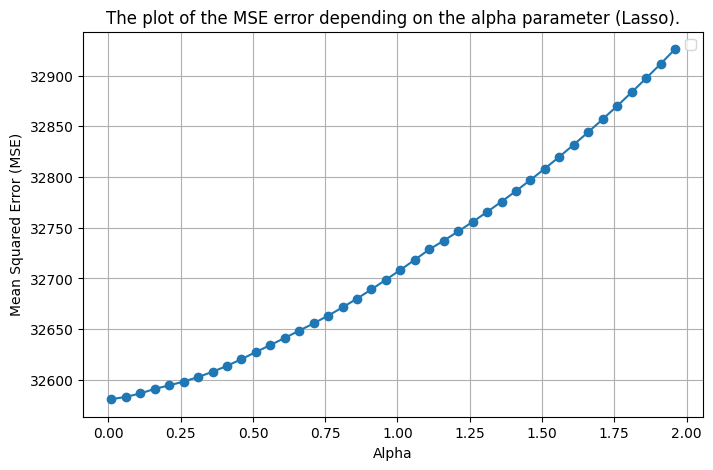

In [9]:
alpha_values = np.arange(0.01, 2, 0.05)

mse_val = []

for alpha in alpha_values:
    regressor = Lasso(alpha=alpha)
    regressor.fit(X_train, y_train)
    pred = regressor.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    mse_val.append(mse)

plt.figure(figsize=(8, 5))
plt.plot(alpha_values, mse_val, marker='o')
plt.title('The plot of the MSE error depending on the alpha parameter (Lasso).')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid(True)
plt.legend()
plt.show()

We can see that applying L1 regularization does not improve the quality of the model.

### We check how L2 regularization will affect our regression model.

C:\Users\patry\AppData\Local\Temp\ipykernel_22952\934444442.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


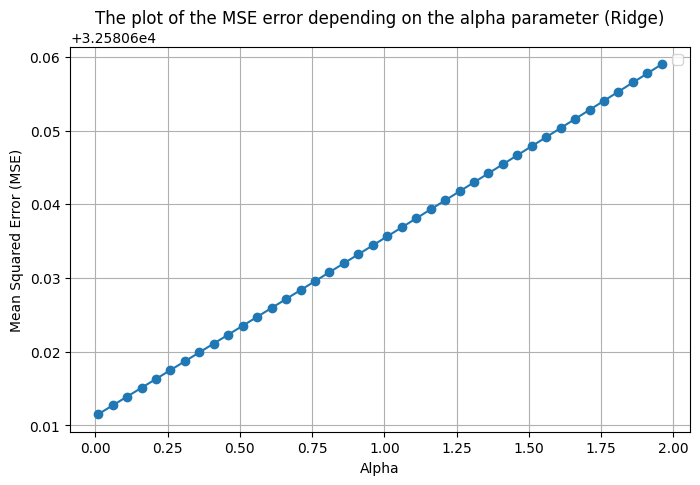

In [10]:
alpha_values = np.arange(0.01, 2, 0.05)

mse_val = []

for alpha in alpha_values:
    regressor = Ridge(alpha=alpha)
    regressor.fit(X_train, y_train)
    pred = regressor.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    mse_val.append(mse)

plt.figure(figsize=(8, 5))
plt.plot(alpha_values, mse_val, marker='o')
plt.title('The plot of the MSE error depending on the alpha parameter (Ridge)')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid(True)
plt.legend()
plt.show()

We can see that the application of L2 regularization also does not improve the model's quality. In this case, we observe that the changes in error depending on the regularization coefficient are very small.

Since no regularization technique has improved the model's performance, this may suggest that our model is not overfitted, or that regularization weakens features that are important for the model.

### We decided to test regression using random forests.

In [11]:
regressor = RandomForestRegressor()
regressor.fit(X_train, y_train)

pred = regressor.predict(X_test)

mse = mean_squared_error(y_test, pred)
rms = np.sqrt(mse)
r2 = r2_score(y_test, pred)
mse_values['pred_random_forest'] = mse
rms_values['pred_random_forest'] = rms
r2_values['pred_random_forest'] = r2

print('MSE:', mse)
print('RMS:', rms)
print('R2:', r2)

MSE: 22067.832768430097
RMS: 148.55245796832207
R2: 0.6247284067432992


We can see a significant improvement compared to the previously used methods. Due to the way random forests work, we can infer that our data is not linearly dependent.

### We are creating custom features based on existing features.

In [12]:
trip_data['precipitation_log'] = np.log(trip_data['precipitation'] + 1)
trip_data['wind_speed_log'] = np.log(trip_data['wind_speed'] + 1)
trip_data['distance_log'] = np.log(trip_data['distance'] + 1)
trip_data['distancextemperature'] = trip_data['distance'] * trip_data['temperature']
trip_data['sunshinexdistance'] = trip_data['sunshine'] * trip_data['distance']
trip_data['precipitationxdistance'] = trip_data['precipitation'] * trip_data['distance']
trip_data['elevationxdistance'] = trip_data['elevation'] * trip_data['distance']
trip_data['distancesqr'] = trip_data['distance'] * trip_data['distance']
trip_data['sunshinesqr'] = trip_data['sunshine'] * trip_data['sunshine']
trip_data['distance^3'] = trip_data['distance'] * trip_data['distance'] * trip_data['distance']
trip_data['sunshine^3'] = trip_data['sunshine'] * trip_data['sunshine'] * trip_data['sunshine']
trip_data['elevationsqr'] = trip_data['elevation'] * trip_data['elevation']
trip_data['elevation^3'] = trip_data['elevation'] * trip_data['elevation'] * trip_data['elevation']

We added several features using logarithms to balance their distribution. We multiplied some features together to see if they influence each other. Features with the highest correlation to the duration feature were raised to the 2nd and 3rd powers to check if they have non-linear dependencies.

### We normalize the new set of features.

In [13]:
X = trip_data.drop(columns=['duration'])
y = trip_data['duration']

scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

### We split the dataset.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y,
    test_size=0.2,
    random_state=0
)

### We create a linear regression model based on the new set of features.

In [15]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

pred = regressor.predict(X_test)

mse = mean_squared_error(y_test, pred)
rms = np.sqrt(mse)
r2 = r2_score(y_test, pred)

mse_values['pred_linear_new'] = mse
rms_values['pred_linear_new'] = rms
r2_values['pred_linear_new'] = r2
print('MSE:', mse)
print('RMS:', rms)
print('R2:', r2)

coefs = dict(zip(X_train.columns, regressor.coef_))

res['pred_linear_new'] = coefs

print('\n')
for key, value in coefs.items():
    print(f"{key}: {value}")

MSE: 32401.329051820412
RMS: 180.0036917727534
R2: 0.4490035109244538


precipitation: 16.04457639900819
temperature: 75.91403246210399
wind_speed: -54.57791746439567
sunshine: 42.16921550818061
is_holiday: 16.866590131885907
is_weekend: 22.520058122959117
distance: 2420.713038365105
elevation: 47.69315551871186
is_sunny: -26932637128578.375
is_cloudy: -26932637128580.1
is_rainy: -26932637128584.508
is_spring: 22641422987229.277
is_summer: 22641422987237.086
is_fall: 22641422987235.492
is_winter: 22641422987243.293
precipitation_log: -22.20772199016491
wind_speed_log: 58.23556288873831
distance_log: -868.1097391245972
distancextemperature: -71.35325717090863
sunshinexdistance: 7.489519843447528
precipitationxdistance: 4.169859958713904
elevationxdistance: 8.384861186040427
distancesqr: -2116.316817168003
sunshinesqr: -71.32466376658098
distance^3: 1134.3388243534885
sunshine^3: 45.708817665498884
elevationsqr: 58.45352455016806
elevation^3: 114.24624459330064


We see a slight improvement in the model's quality compared to the previous multiple regression model, but the dominant feature in the model remains the distance feature. We also observe that the logarithm of this feature and its higher powers play a significant role. However, the change in our model is minimal, and the coverage of the trip duration variability remains almost the same.

### We check the optimal number of features for the new feature set using Forward Stepwise.

C:\Users\patry\AppData\Local\Temp\ipykernel_22952\1389051037.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


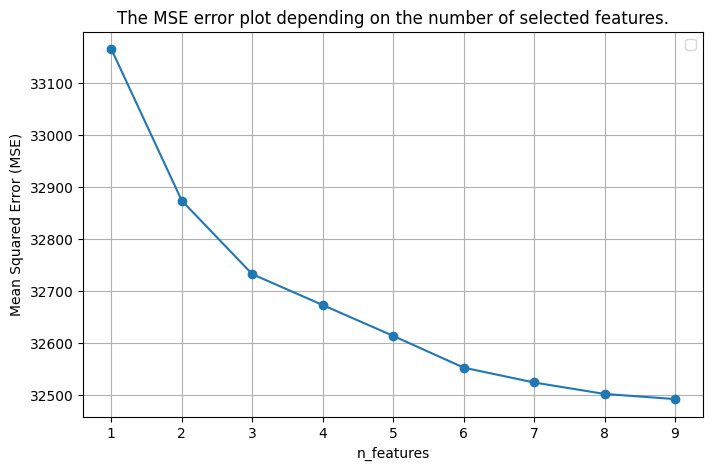

In [16]:
mse_val = []

n_features = np.arange(1, 10, 1)

for n_feature in n_features:
    selector = SequentialFeatureSelector(LinearRegression(),
                                          n_features_to_select=n_feature,
                                          direction='forward',
                                          scoring='neg_mean_squared_error')
    selected_features_forward = selector.fit(X_train, y_train).get_feature_names_out()

    regressor = LinearRegression()
    regressor.fit(X_train[selected_features_forward], y_train)

    pred = regressor.predict(X_test[selected_features_forward])

    mse = mean_squared_error(y_test, pred)
    mse_val.append(mse)

plt.figure(figsize=(8, 5))
plt.plot(n_features, mse_val, marker='o')
plt.title('The MSE error plot depending on the number of selected features.')
plt.xlabel('n_features')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid(True)
plt.legend()
plt.show()

The best choice is 8 features – we check the linear regression model for the 8 selected features.

In [17]:
selector = SequentialFeatureSelector(LinearRegression(),
                                          n_features_to_select=8,
                                          direction='forward',
                                          scoring='neg_mean_squared_error')
selected_features_forward = selector.fit(X_train, y_train).get_feature_names_out()
print(selected_features_forward)

['temperature' 'sunshine' 'is_weekend' 'distance' 'elevation'
 'distance_log' 'elevationsqr' 'elevation^3']


We can see that the features with the largest coefficients from the previous model were selected. Among the chosen features, we also have the ones we added, such as distance^3 and distance_log. This again shows that the distance feature is the most important for the model and has the greatest influence on it, but it does not necessarily describe the duration feature with a linear relationship.

In [18]:
regressor = LinearRegression()
regressor.fit(X_train[selected_features_forward], y_train)

pred = regressor.predict(X_test[selected_features_forward])

mse = mean_squared_error(y_test, pred)
rms = np.sqrt(mse)
r2 = r2_score(y_test, pred)

mse_values['pred_forward_new'] = mse
rms_values['pred_forward_new'] = rms
r2_values['pred_forward_new'] = r2
print('MSE:', mse)
print('RMS:', rms)
print('R2:', r2)

coefs = dict(zip(selected_features_forward, regressor.coef_))

res['pred_forward_new'] = coefs

print('\n')
for key, value in coefs.items():
    print(f"{key}: {value}")

MSE: 32501.684619670836
RMS: 180.28223600696447
R2: 0.4472969276711456


temperature: 43.205377982565736
sunshine: 20.067837186730273
is_weekend: 22.89019070458769
distance: 939.5837828540815
elevation: 50.71686717403847
distance_log: -143.8397845424496
elevationsqr: 58.24525854592668
elevation^3: 113.55254325023567


The feature selection worsened the model's performance. We can see that the features related to distance still have the greatest influence on the model.

### Testing regression using random forests on the new features.

In [19]:
regressor = RandomForestRegressor()
regressor.fit(X_train, y_train)

pred = regressor.predict(X_test)

mse = mean_squared_error(y_test, pred)
rms = np.sqrt(mse)
r2 = r2_score(y_test, pred)
mse_values['pred_random_forest_new'] = mse
rms_values['pred_random_forest_new'] = rms
r2_values['pred_random_forest_new'] = r2

print('MSE:', mse)
print('RMS:', rms)
print('R2:', r2)

MSE: 21889.934614462458
RMS: 147.95247417485947
R2: 0.6277536301251062


### Since the feature "distance" has the greatest impact on the result, we decided to check the results of a polynomial regression model based on the "distance" feature.

C:\Users\patry\AppData\Local\Temp\ipykernel_22952\1923010154.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


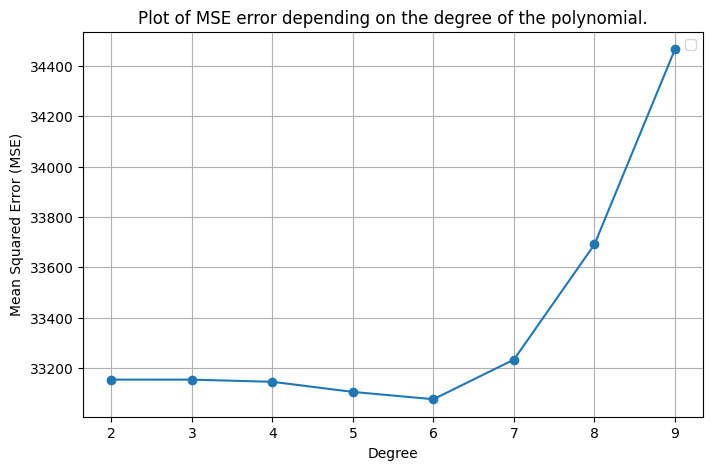

In [21]:
mse_val = []

degrees = np.arange(2, 10, 1)

for degree in degrees:
    poly = PolynomialFeatures(degree=degree)
    poly_features = poly.fit_transform(trip_data['distance'].to_numpy().reshape(-1, 1))

    X_train, X_test, y_train, y_test = train_test_split(
        poly_features,
        y,
        test_size=0.2,
        random_state=0
    )

    regressor = LinearRegression()
    regressor.fit(X_train, y_train)

    pred = regressor.predict(X_test)

    mse = mean_squared_error(y_test, pred)
    mse_val.append(mse)

plt.figure(figsize=(8, 5))
plt.plot(degrees, mse_val, marker='o')
plt.title('Plot of MSE error depending on the degree of the polynomial.')
plt.xlabel('Degree')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid(True)
plt.legend()
plt.show()

The best choice is the 6th degree polynomial.

In [22]:
poly = PolynomialFeatures(degree=6)
poly_features = poly.fit_transform(trip_data['distance'].to_numpy().reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(
    poly_features,
    y,
    test_size=0.2,
    random_state=0
)

regressor = LinearRegression()
regressor.fit(X_train, y_train)

pred = regressor.predict(X_test)

mse = mean_squared_error(y_test, pred)
rms = np.sqrt(mse)
r2 = r2_score(y_test, pred)

mse_values['pred_poly_new'] = mse
rms_values['pred_poly_new'] = rms
r2_values['pred_poly_new'] = r2
print('MSE:', mse)
print('RMS:', rms)
print('R2:', r2)

coefs = dict(zip(['intercept', 'distance', 'distance^2', 'distance^3'], regressor.coef_))

res['pred_poly_new'] = coefs

print('\n')
for key, value in coefs.items():
    print(f"{key}: {value}")

MSE: 33075.97700086605
RMS: 181.86802083067283
R2: 0.4375308750121537


intercept: 0.0
distance: -1.0169744448825413e-11
distance^2: 1.5449754709615204e-10
distance^3: 1.3435016572161246e-07


We can see that the polynomial regression model based on the distance feature performed worse than the other models. This shows that the distance feature alone is not sufficient to describe our target variable. However, since the model's result is not significantly different from the results of other models, we can conclude that the distance feature is a very important component.

### Model Summary

In [23]:
for key, value in mse_values.items():
    print(f"{key}: {value}")

pred_linear: 32580.6114393005
pred_forward: 32599.825725083218
pred_random_forest: 22067.832768430097
pred_linear_new: 32401.329051820412
pred_forward_new: 32501.684619670836
pred_random_forest_new: 21889.934614462458
pred_poly_new: 33075.97700086605


In [25]:
for key, value in rms_values.items():
    print(f"{key}: {value}")

pred_linear: 180.50100121412208
pred_forward: 180.55421824228648
pred_random_forest: 148.55245796832207
pred_linear_new: 180.0036917727534
pred_forward_new: 180.28223600696447
pred_random_forest_new: 147.95247417485947
pred_poly_new: 181.86802083067283


In [26]:
for key, value in r2_values.items():
    print(f"{key}: {value}")

pred_linear: 0.4459547481438709
pred_forward: 0.4456280021641168
pred_random_forest: 0.6247284067432992
pred_linear_new: 0.4490035109244538
pred_forward_new: 0.4472969276711456
pred_random_forest_new: 0.6277536301251062
pred_poly_new: 0.4375308750121537


We can see that the regression using random forests performed the best. We noticed that adding new features brought some improvement, but it was minimal. This does not significantly impact the overall performance of the model.

The results we obtained are not very good. This could mean that there are some features that describe the trip duration well, but they are not present in our dataset. With the dataset we have, we are able to explain about 60% of the variability in the target feature. Therefore, further expanding the dataset could help us build a better model that would more accurately describe the trip duration.

### Summary of the obtained coefficients

In [27]:
for key, value in res.items():
    print(key)
    for k, v in value.items():
        print(f"\t{k}: {v}")
    print()

pred_linear
	precipitation: -7.951823331659774
	temperature: 52.70764330645079
	wind_speed: -1.5506168176004884
	sunshine: 19.52061272047382
	is_holiday: 17.072797620837363
	is_weekend: 22.65995614382332
	distance: 874.283872895788
	elevation: 86.73899644864545
	is_sunny: -22842904102175.1
	is_cloudy: -22842904102176.277
	is_rainy: -22842904102181.008
	is_spring: 14670206371089.922
	is_summer: 14670206371097.555
	is_fall: 14670206371096.123
	is_winter: 14670206371104.656

pred_forward
	temperature: 45.358100039239915
	sunshine: 22.249399536426715
	is_weekend: 23.170753900661595
	distance: 874.1840274348702
	elevation: 86.66018389495527
	is_spring: -7.804653440407845

pred_linear_new
	precipitation: 16.04457639900819
	temperature: 75.91403246210399
	wind_speed: -54.57791746439567
	sunshine: 42.16921550818061
	is_holiday: 16.866590131885907
	is_weekend: 22.520058122959117
	distance: 2420.713038365105
	elevation: 47.69315551871186
	is_sunny: -26932637128578.375
	is_cloudy: -26932637128580

We can see that in every model, the feature "distance" dominates the influence of other features, which aligns with our hypothesis. It is surprising how little impact precipitation and wind speed have on the model. The feature "is_sunny" may have been ignored by the model due to the presence of the "sunshine" feature, which covered its influence on the model. We can also notice that the impact of the "elevation" feature stands out among the other features.